In [1]:
# Libraries

import os
import platform
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.report import report_load
from source.python.report import report_concat
from source.python.report import report_filter
from source.python.report import report_plot
from source.python.io     import loader
from source.python        import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

In [4]:
# List reports folder content

ROOT_DIR = os.path.join(ROOT, 'reports')

for index, name in enumerate(os.listdir(ROOT_DIR), start = 0) :
	path_l0 = os.path.join(ROOT_DIR, name)

	if index == 0 : print('{} :'.format(path_l0))
	else          : print('\n{} :'.format(path_l0))

	for name in os.listdir(path_l0) :
		path_l1 = os.path.join(path_l0, name)

		if not os.path.exists(path_l1) :
			continue

		for name in os.listdir(path_l1) :
			print('...\\{}'.format(name))

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\bert :
...\fc3-cat-11-6-72-promoter-adam-f0-0250-global-mean
...\fc3-cat-12-3-72-promoter-adam-f0-0250-global-mean
...\fc3-cat-12-6-00-promoter-adam-f0-0250-global-mean
...\fc3-cat-12-6-72-promoter-adam-f0-0250-global-mean
...\fc3-cat-12-6-72-promoter-lamb-f0-0250-global-mean
...\fc3-cat-12-6-72-transcript-adam-f0-0150-global-mean
...\fc3-cat-12-6-77-promoter-adam-f0-0250-tissue-mean-seedling
...\fc3-def-09-6-72-promoter-adam-f0-0250-global-mean
...\fc3-def-11-6-72-promoter-adam-f0-0250-global-mean
...\fc3-def-12-3-72-promoter-adam-f0-0250-global-mean
...\fc3-def-12-6-00-promoter-adam-f0-0250-global-mean
...\fc3-def-12-6-00-promoter-adam-f3-0150-global-mean
...\fc3-def-12-6-72-promoter-adam-f0-0250-global-mean
...\fc3-def-12-6-72-promoter-adam-f3-0250-global-mean
...\fc3-def-12-6-72-promoter-lamb-f0-0250-global-mean
...\fc3-def-12-6-77-promoter-adam-f0-0250-tissue-mean-seedling
...\fc3-rnn-09-6-72-promoter-adam-f0-0250-glob

# 1. CNN

## 1.1 Model

In [5]:
# Load cnn model reports

report_cnn_model = report_load.load_cnn_reports(
	root = ROOT_DIR
)

### 1.1.1 Regression

In [6]:
# Display model performance for regression

report_cnn_model['regression']

,Model,Type,Filter,Epochs,Target_0,Target_1,Target_2,Optimizer,Learning_Rate,Momentum,Decay,Scheduler,Batch_Size,Dropout,Epoch,Valid_MSE,Eval_MSE,Eval_MAE,Eval_R2
3,washburn,transcript,f0,500,global,mean,None,adam,0.001815871,0.661281875,0.000395388,exponential,32,0.470,32,0.616498342,0.557999268,0.599265450,0.308064580
2,washburn,transcript,f0,500,tissue,mean,None,adam,0.001815871,0.661281875,0.000395388,exponential,32,0.470,23,0.656342707,0.655258795,0.652996713,0.268879235
1,washburn,transcript,f0,500,tissue,mean,seedling,adam,0.001815871,0.661281875,0.000395388,exponential,32,0.470,26,0.591230285,0.647375628,0.650652180,0.261054575
7,zrimec,transcript,f0,500,global,mean,None,adam,0.000855270,0.830793560,0.049112288,linear,64,0.090,43,0.615248383,0.648892189,0.655135765,0.250445098
5,zrimec,transcript,f0,500,tissue,mean,seedling,adam,0.000855270,0.830793560,0.049112288,linear,64,0.090,31,0.673128116,0.652908151,0.659634473,0.246836364
6,zrimec,transcript,f0,500,tissue,mean,None,adam,0.000855270,0.830793560,0.049112288,linear,64,0.090,59,0.686891409,0.705667055,0.685929240,0.233080164
0,washburn,transcript,f0,500,tissue,mean,explode,adam,0.001815871,0.661281875,0.000395388,exponential,32,0.470,11,0.658476066,0.709610886,0.696640393,0.215825811
4,zrimec,transcript,f0,500,tissue,mean,explode,adam,0.000855270,0.830793560,0.049112288,linear,64,0.090,21,0.692038413,0.705530821,0.678654226,0.215524673


### 1.1.2 Classification

In [7]:
# Display model performance for classification

report_cnn_model['classification']

,Model,Type,Filter,Epochs,Target_0,Target_1,Target_2,Optimizer,Learning_Rate,Momentum,Decay,Scheduler,Batch_Size,Dropout,Epoch,Valid_Entropy,Eval_Entropy,Eval_Accuracy,Eval_F1,Eval_AUROC


## 1.2 Tune Model

In [8]:
# Load tune model reports

report_tune_model = report_load.load_cnn_tune_reports(
	root = ROOT_DIR,
	show = False,
	n    = 5
)

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\tune\cnn-regression\zrimec-transcript-f0-0500-25-77-tissue-mean-explode\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\tune\cnn-regression\zrimec-transcript-f0-1000-25-72-global-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\tune\cnn-regression\zrimec-transcript-f0-1000-25-72-tissue-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\tune\cnn-regression\zrimec-transcript-f3-0500-25-00-global-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\tune\cnn-regression\washburn-transcript-f0-0250-25-77-tissue-mean-explode\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\tune\cnn-regression\washburn-transcript-f0-0500-25-72-global-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\tune\cnn-regression\washburn-transcript-f0-0500-25-72-tissue-mean\report.csv
C:\Developer

### 1.2.1 Regression

In [9]:
# Display overall regression prediction

R2_THRESHOLD = 0.00

for key, dataframe in report_tune_model['regression'].items() :
	nan_mse = dataframe['valid_loss'].isnull().values.ravel().sum()
	pos_r2  = dataframe[dataframe['valid_r2'] > R2_THRESHOLD]['valid_r2'].count()
	neg_r2  = dataframe[dataframe['valid_r2'] < R2_THRESHOLD]['valid_r2'].count()

	print('{:64s} : Size = {:4d} || NaN Loss = {:4d} || Pos R2 = {:4d} || Neg R2 = {:4d}'.format(key, len(dataframe), nan_mse, pos_r2, neg_r2))

zrimec-transcript-f0-0500-25-77-tissue-mean-explode              : Size =  500 || NaN Loss =   44 || Pos R2 =  233 || Neg R2 =  223
zrimec-transcript-f0-1000-25-72-global-mean                      : Size = 1000 || NaN Loss =  243 || Pos R2 =  198 || Neg R2 =  559
zrimec-transcript-f0-1000-25-72-tissue-mean                      : Size = 1000 || NaN Loss =  565 || Pos R2 =   86 || Neg R2 =  349
zrimec-transcript-f3-0500-25-00-global-mean                      : Size = 1000 || NaN Loss =    0 || Pos R2 =  327 || Neg R2 =  673
washburn-transcript-f0-0250-25-77-tissue-mean-explode            : Size =  250 || NaN Loss =   24 || Pos R2 =  170 || Neg R2 =   56
washburn-transcript-f0-0500-25-72-global-mean                    : Size =  500 || NaN Loss =  235 || Pos R2 =  172 || Neg R2 =   93
washburn-transcript-f0-0500-25-72-tissue-mean                    : Size =  500 || NaN Loss =    6 || Pos R2 =  306 || Neg R2 =  188
washburn-transcript-f3-0250-25-00-global-mean                    : Size =  5

In [10]:
# Concat reports and display top few

report = report_concat.concat_cnn_tune_reports(
	reports = report_tune_model,
	mode    = 'regression',
	n       = 25
)

report

,Model,Sequence,Filter,Target0,Target1,Target2,ID,Valid_MSE,Valid_MAE,Valid_R2,Train_MSE,Epoch,Optimizer,Learning_Rate,Decay,Scheduler,Batch_Size,Dropout
0,washburn,transcript,f0,tissue,mean,explode,c07e6432,0.635280578,0.639042504,0.319446060,0.621541332,25,adam,0.001025030,0.002270048,linear,64,0.423
1,washburn,transcript,f0,tissue,mean,explode,e3290128,0.621668590,0.636150431,0.315615270,0.591602998,25,adam,0.000267025,0.005743363,step,32,0.474
2,washburn,transcript,f0,tissue,mean,explode,78056277,0.640462652,0.646407102,0.313010570,0.599876152,25,adam,0.000526629,0.007077184,exponential,64,0.394
3,washburn,transcript,f0,tissue,mean,explode,9a7471c3,0.652823501,0.646436032,0.309993330,0.647246957,25,adam,0.000734194,0.000168554,plateau,128,0.426
4,washburn,transcript,f0,tissue,mean,explode,8039f99d,0.644801771,0.649618278,0.307750500,0.596913834,25,adam,0.000123382,0.007468796,plateau,64,0.326
5,washburn,transcript,f0,tissue,mean,explode,9a2bc047,0.646856915,0.650021511,0.305930530,0.567277230,25,adam,0.000217920,0.009510614,exponential,64,0.398
6,washburn,transcript,f0,tissue,mean,explode,0b5594a1,0.649560788,0.651824468,0.304297400,0.603778491,25,adam,0.000265706,0.009725213,exponential,64,0.471
7,washburn,transcript,f0,global,mean,None,e1e1c21d,0.568019972,0.607647874,0.298890920,0.562816817,25,adam,0.000462248,0.001384209,exponential,32,0.489
8,washburn,transcript,f0,tissue,mean,explode,3444ffaa,0.636669345,0.632291760,0.298259400,0.561920608,25,adam,0.000176379,0.006127512,step,32,0.451
9,washburn,transcript,f0,global,mean,None,c4f47f56,0.563137508,0.605040411,0.296825740,0.558655353,25,adam,0.001815871,0.000395388,exponential,32,0.470


### 1.2.2 Classification

In [11]:
# Concat reports and display top few

report = report_concat.concat_cnn_tune_reports(
	reports = report_tune_model,
	mode    = 'classification',
	n       = None
)

report

## 1.3 Tune Data

In [12]:
# Display top few results for each tune configuration

report_tune_data = report_load.load_data_tune_reports(
	root = ROOT_DIR,
	show = False,
	n    = 25
)

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\tune\data-regression\zrimec-transcript-f0-1000-25-global-mean\report.csv


### 1.3.1 Regression

In [13]:
# Concat reports and display top few

report = report_concat.concat_data_tune_reports(
	reports = report_tune_data,
	mode    = 'regression',
	n       = 25
)

report

,Model,Sequence,Filter,Target0,Target1,Target2,ID,Valid_MSE,Valid_MAE,Valid_R2,Train_MSE,Epoch,Lambda
0,zrimec,transcript,f0,global,mean,None,599af719,0.648150855,0.646805835,0.224130330,0.554547037,25,-0.145526611
1,zrimec,transcript,f0,global,mean,None,a5e2719e,0.226589170,0.387015893,0.215550740,0.221942309,25,-0.436219123
2,zrimec,transcript,f0,global,mean,None,53dbabfc,0.786596467,0.709209984,0.211554000,0.637495679,25,-0.105521385
3,zrimec,transcript,f0,global,mean,None,6dc72e0a,1.101029199,0.838361180,0.208666850,1.014267302,10,-0.034234074
4,zrimec,transcript,f0,global,mean,None,84f7b5c1,0.378160561,0.508789048,0.207865880,0.372209152,10,-0.289212403
5,zrimec,transcript,f0,global,mean,None,756fdc23,0.106111770,0.264295316,0.205602290,0.104107744,25,-0.710563702
6,zrimec,transcript,f0,global,mean,None,a38b2f7b,0.638232757,0.656157337,0.201600070,0.615477707,10,-0.158487631
7,zrimec,transcript,f0,global,mean,None,d937154c,0.092418812,0.249240113,0.195299630,0.091526112,25,-0.772120862
8,zrimec,transcript,f0,global,mean,None,ccb9118d,0.414475848,0.537225624,0.194477920,0.403514192,10,-0.268938321
9,zrimec,transcript,f0,global,mean,None,17870491,0.807163757,0.733480325,0.194213390,0.759723090,10,-0.105851402


### 1.3.1 Classification

In [14]:
# Concat reports and display top few

report = report_concat.concat_data_tune_reports(
	reports = report_tune_data,
	mode    = 'classification',
	n       = 25
)

report

## 1.4 Tune Feature

In [15]:
# Display top few results for each tune configuration

report_tune_feature = report_load.load_feature_tune_reports(
	root = ROOT_DIR,
	show = False,
	n    = 25
)

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\tune\feature-regression\72-2500-50\report.csv


### 1.4.1 Regression

In [16]:
# Concat reports and display top few

report = report_concat.concat_feature_tune_reports(
	reports = report_tune_feature,
	mode    = 'regression',
	n       = None
)

report = report[report['Target1'] == 'mean'].head(n = 50)
report

,Model,Filter,Target0,Target1,Target2,ID,Valid_MSE,Valid_MAE,Valid_R2,Train_MSE,Epoch,Optimizer,Learning_Rate,Scheduler,Batch_Size,Dropout,Features
9,densefc3,f2,global,mean,None,5c607_00678,0.551020705,0.598459172,0.297313200,0.592728451,50,adam,0.000852121,linear,128,0.405,128
11,densefc3,f2,global,mean,None,5c607_01958,0.548143717,0.590878751,0.289928400,0.577354440,50,adam,0.000275309,linear,64,0.031,256
18,densefc3,f2,global,mean,None,5c607_02294,0.542286778,0.591627006,0.280391570,0.565754883,50,adam,0.000610768,linear,32,0.076,64
19,densefc2,f2,global,mean,None,5c607_00674,0.565699757,0.607883594,0.277992130,0.624066475,50,adam,0.000852121,linear,128,0.405,128
21,densefc3,f1,global,mean,None,5c607_00677,0.617055148,0.626873255,0.276909620,0.623846843,50,adam,0.000852121,linear,128,0.405,128
22,densefc3,f0,global,mean,None,5c607_00676,0.617055148,0.626873255,0.276909620,0.623846843,50,adam,0.000852121,linear,128,0.405,128
23,densefc2,f2,global,mean,None,5c607_01954,0.562031141,0.603443084,0.274045850,0.596032894,50,adam,0.000275309,linear,64,0.031,256
24,densefc2,f0,global,mean,None,5c607_01952,0.620809489,0.638579311,0.271471530,0.623604271,50,adam,0.000275309,linear,64,0.031,256
25,densefc2,f1,global,mean,None,5c607_01953,0.620809489,0.638579311,0.271471530,0.623604271,50,adam,0.000275309,linear,64,0.031,256
26,densefc3,f0,global,mean,None,5c607_02292,0.611499524,0.630684439,0.269977480,0.594330438,50,adam,0.000610768,linear,32,0.076,64


### 1.4.2 Classification

In [17]:
# Concat reports and display top few

report = report_concat.concat_feature_tune_reports(
	reports = report_tune_feature,
	mode    = 'classification',
	n       = 25
)

report

# 2. DNABert

## 2.1 Model

In [18]:
# Load bert model reports

report_bert_model = report_load.load_bert_reports(
	root = ROOT_DIR,
	show = False
)

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\bert\regression\fc3-def-09-6-72-promoter-adam-f0-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\bert\regression\fc3-def-11-6-72-promoter-adam-f0-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\bert\regression\fc3-def-12-3-72-promoter-adam-f0-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\bert\regression\fc3-def-12-6-00-promoter-adam-f0-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\bert\regression\fc3-def-12-6-00-promoter-adam-f3-0150-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\bert\regression\fc3-def-12-6-72-promoter-adam-f0-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\bert\regression\fc3-def-12-6-72-promoter-adam-f3-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\bert\regression\fc3-def-12-6-72-pr

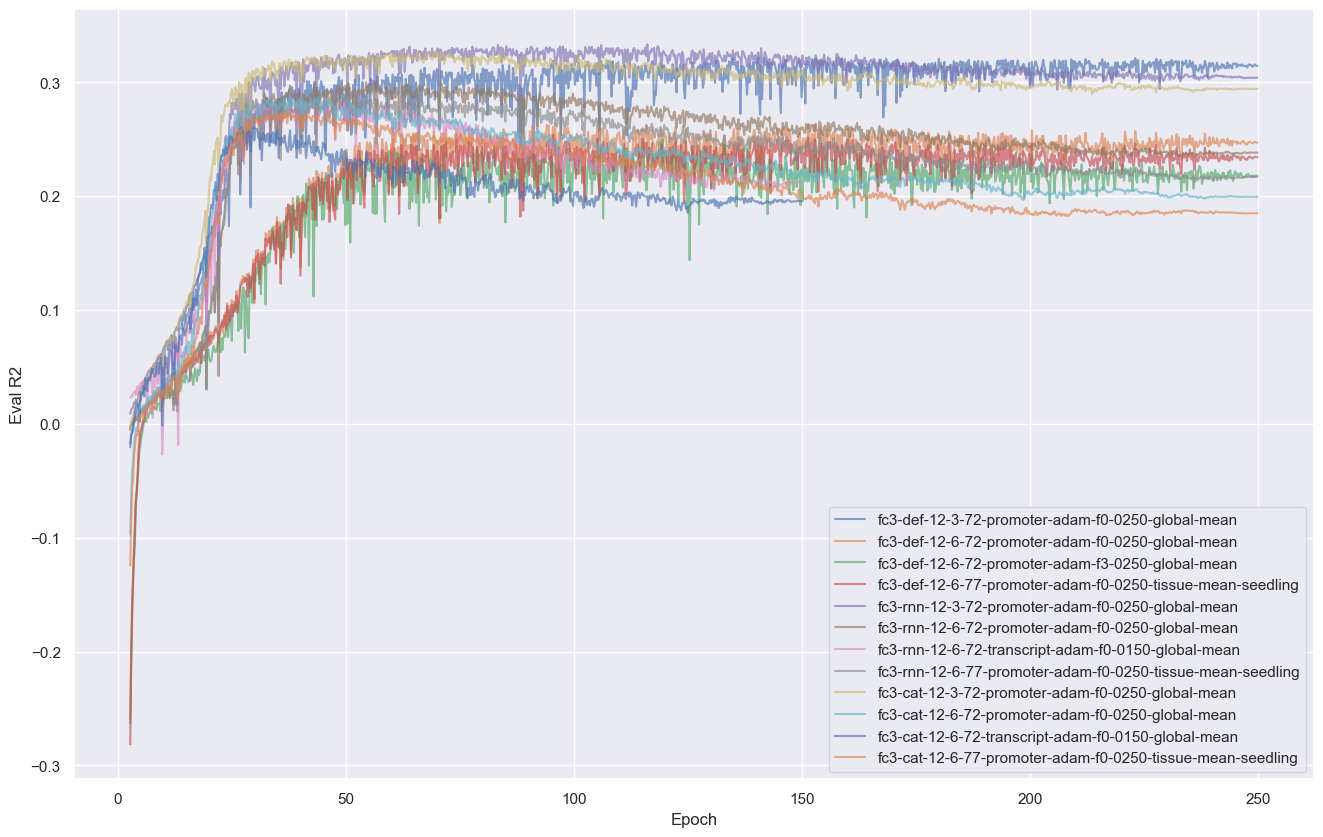

In [19]:
# Plot

report_plot.models_bert_r2(
	data     = report_filter.filter_bert_reports(
		reports = report_bert_model,
		keep_only = ['12'],
		drop_only = ['lamb', '6-00']
	),
	mode     = 'regression',
	x        = 12,
	y        = None,
	filename = None,
	step     = 'epoch'
)

In [20]:
# Concat reports and display top few

report = report_concat.concat_bert_reports(
	data      = report_bert_model,
	mode      = 'regression',
	metric    = 'eval_r2',
	ascending = False
)

report = report.head(n = 25)
report

,Mode,Arch,Type,Layer,Kmer,Feature,Filter,Sequence,Optimizer,Epochs,Target0,Target1,Target2,Eval_R2,Eval_ME,Eval_MAPE,Eval_MAE,Learning_Rate,Step,Epoch
11,regression,fc3,rnn,12,3,72,f0,promoter,adam,250,global,mean,None,0.333458288,2.930676500,1.397022400,0.604679100,0.000029759,56300,116
18,regression,fc3,cat,12,3,72,f0,promoter,adam,250,global,mean,None,0.327126697,2.941112000,1.364534600,0.609815800,0.000041672,30300,62
2,regression,fc3,def,12,3,72,f0,promoter,adam,250,global,mean,None,0.321766655,2.914049100,1.394722600,0.614872800,0.000024353,68100,140
13,regression,fc3,rnn,12,6,72,f0,promoter,adam,250,global,mean,None,0.300013136,3.107515600,1.470248500,0.622333200,0.000043001,27400,56
16,regression,fc3,rnn,12,6,77,f0,promoter,adam,250,tissue,mean,seedling,0.288722027,3.111530500,6.646839600,0.646375400,0.000044330,24500,50
20,regression,fc3,cat,12,6,72,f0,promoter,adam,250,global,mean,None,0.286946140,3.087912300,1.499442800,0.629488300,0.000045796,21300,43
15,regression,fc3,rnn,12,6,72,f0,transcript,adam,150,global,mean,None,0.283373088,3.110311000,1.498430500,0.636298540,0.000040664,19500,40
23,regression,fc3,cat,12,6,77,f0,promoter,adam,250,tissue,mean,seedling,0.274958905,3.181850400,6.500231300,0.650259140,0.000047171,18300,37
5,regression,fc3,def,12,6,72,f0,promoter,adam,250,global,mean,None,0.264138765,3.325360300,1.497594600,0.644396200,0.000034250,46500,95
22,regression,fc3,cat,12,6,72,f0,transcript,adam,150,global,mean,None,0.261985297,3.145094600,1.528921500,0.642900400,0.000042650,16900,34
